# 01 Data Preparation

This notebook in particular focuses on preparing and cleaning the dataset, in order to make it ready for network construction and analysis. Therefore, the first step is to import the three main datasets that will be subject of study in this project, corresponding to the three main Reddit fora: r/Incel, r/Braincels (both now defunct) and r/IncelExit (which is an active online group that help men wanting to leave the incel community). These three datasets are made available by Golbeck[1], whose article 'A Dataset for The Study of Online Radicalization Through Incel Forum Archives' served as a main inspiration for this study. 

The three datasets are then loaded through pandas, stored in a dictionary for easy access and then asserting column titles set by us to each column. At the end of this cell, a quick peek on general numbers is made, counting posts and users per dataset.

In [ ]:
import pandas as pd
import math
import os

# ---- Load the four main tables (TSV) ----
#incels_is_comments   = pd.read_csv("data/incels.is_AllComments.anon",           sep="\t", encoding="utf-8", on_bad_lines="skip")
reddit_incel   = pd.read_csv("data/reddit-incel-posts.anon.txt",          sep="\t", encoding="utf-8", dtype = str)
reddit_incelexit = pd.read_csv("data/reddit-IncelExit-posts.anon.txt",          sep="\t", encoding="utf-8", engine="python", quoting=3, on_bad_lines="skip", dtype=str)
#saidit_incel_posts   = pd.read_csv("data/saidit-incel-posts.anon.txt",          sep="\t", encoding="utf-8", on_bad_lines="skip")
reddit_braincels   = pd.read_csv("data/reddit-braincels-posts.anon.txt",          sep="\t", encoding="utf-8", on_bad_lines="skip", dtype=str)

reddit_braincels = reddit_braincels.iloc[1:].reset_index(drop=True)

dfs = {
    #"incels_is_comments": incels_is_comments,
    "reddit_incel": reddit_incel,
    "reddit_incelexit": reddit_incelexit,
    #"saidit_incel_posts": saidit_incel_posts,
    "reddit_braincels": reddit_braincels
}

# streamline column names 
colnames = ["link", "comment_id", "user_id", "parent", "timestamp", "title", "text"]
for name, df in dfs.items():
    df.columns = colnames

# Quick peek so you can see they loaded
for name, df in dfs.items():
    print(f"{name}_posts: {df.shape[0]}")
    #display(df.head(10))

print("Unique users in each dataset:")
for name, df in dfs.items():
    print(f"{name}: {len(df['user_id'].unique())}")

# #total unique users across all datasets
# all_users = pd.concat([df['user_id'] for df in dfs.values()]).unique()
# print(f"Total unique users across all datasets: {len(all_users)}")

# #total length of all datasets combined 
# total_length = sum(df.shape[0] for df in dfs.values())
# print(f"Total length of all datasets combined: {total_length}")

reddit_incel_posts: 988061
reddit_incelexit_posts: 111083
reddit_braincels_posts: 2216973
Unique users in each dataset:
reddit_incel: 29877
reddit_incelexit: 4005
reddit_braincels: 69303


From an initial insight, it is possible to observe that there is some discrepancy on the values of posts and users obtained for each subreddit between our loaded data and the ones reported by [1]. Thus, a more in-depth look into the datasets was required to understand the reasons behind this descrepancy. The following cells explain our main findings and the methods used to overcome them.

The first forum analyzed was the r/IncelExit subreddit, simply due to its smaller size, meaning it could be easier to identify any systematic problem with the data. It was identified that the dataset presented some incorrect data under the "link" column, referring to different pages other than the r/IncelExit (e.g. github or youtube links), causing the incorrect increase in number of posts observed. Therefore, a "mask" was applied, in order to consider as valid only the dataset rows where the "link" column contained the 'r/IncelExit' string, reducing the number of posts to exact same one as seen in [1].

Additionally, for each subset an additional column named 'Original File Source' was added identifying the original subreddit from which each post arises (useful later for the compilation of each data subset and network construction).

In [21]:
valid_posts_incelexit_posts_idx = reddit_incelexit['link'].str.contains(r'r/IncelExit')

valid_posts_incelexit = reddit_incelexit[valid_posts_incelexit_posts_idx]

valid_posts_incelexit['timestamp'] = pd.to_datetime(valid_posts_incelexit['timestamp'], unit='s', errors='coerce')
valid_posts_incelexit.sort_values('timestamp', inplace=True)

valid_posts_incelexit["Original File Source"] = "r/IncelExit"

print('Posts with valid link in IncelExit dataset:', valid_posts_incelexit_posts_idx.sum())
#valid_posts_incelexit.head() 

C:\Users\Renato Thieleke\AppData\Local\Temp\ipykernel_2428\3850424960.py:5: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  valid_posts_incelexit['timestamp'] = pd.to_datetime(valid_posts_incelexit['timestamp'], unit='s', errors='coerce')


Posts with valid link in IncelExit dataset: 110990


C:\Users\Renato Thieleke\AppData\Local\Temp\ipykernel_2428\3850424960.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_posts_incelexit['timestamp'] = pd.to_datetime(valid_posts_incelexit['timestamp'], unit='s', errors='coerce')
C:\Users\Renato Thieleke\AppData\Local\Temp\ipykernel_2428\3850424960.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_posts_incelexit.sort_values('timestamp', inplace=True)
C:\Users\Renato Thieleke\AppData\Local\Temp\ipykernel_2428\3850424960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

For the r/Incel subreddit, the troubleshoot was slightly more complicated, since the difference was quite small (~200 posts) for a total number of posts of close to 1 million. In this case, the opposite case of r/IncelExit was happening, meaning the loaded dataset in this study was presenting a smaller number of posts than the one presented in [1]. 

With the support of DataWrangler for dataset visulization and a visual inspection of the original .txt datafile, it was observed that some rows were being skipped, thus not being counted as posts. The reason behind it was that some of the text under the 'text' column did not end with quotes ("), so pandas was concatenating some comments/posts together. As such, the solution adopted was to rewrite the original .txt files and adding a quote symbol (") to lines which had an odd number of them, creating a new .txt file that would be then used as the valid dataset. After applying this method, results found the same number of posts and users as the source paper [1].

In [22]:
input_path = "data/reddit-incel-posts.anon.txt"
output_path = "data/reddit-incel-posts_with_quotes.txt"

#adding quotation marks at the end of each
with open(input_path, encoding="utf-8", errors="ignore") as f_in, \
     open(output_path, "w", encoding="utf-8", newline="") as f_out:
    for line in f_in:
        if line.count('"') % 2 != 0:
            line = line.rstrip("\n") + '"\n'
        f_out.write(line)

valid_posts_incels = pd.read_csv(
    output_path,
    sep="\t",
    encoding="utf-8",
    dtype=str,
    header=None,
    names=colnames
)

valid_posts_incels['timestamp'] = pd.to_datetime(valid_posts_incels['timestamp'], unit='s', errors='coerce')
valid_posts_incels.sort_values('timestamp', inplace=True)

valid_posts_incels["Original File Source"] = "r/Incel"

print('Number of users r/Incel: ', len(valid_posts_incels['user_id'].unique()))
print("Number of posts r/Incel:", len(valid_posts_incels))

C:\Users\Renato Thieleke\AppData\Local\Temp\ipykernel_2428\1097649295.py:21: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  valid_posts_incels['timestamp'] = pd.to_datetime(valid_posts_incels['timestamp'], unit='s', errors='coerce')


Number of users r/Incel:  29877
Number of posts r/Incel: 988244


For the r/Braincels dataset, the process applied for the r/Incels dataset was used as well, since the number of posts was also lower than the ones found in [1]. After applying this method, a small difference was still observed in comparison with the source paper. However, this difference was considered to be negligeble (~50 posts over almost 2.5 million) and considered that it would not affect the overall community analysis, so a decision was made to proceed with this disagreement. 

In [23]:
import csv
input_path = "data/reddit-braincels-posts.anon.txt"
output_path = "data/reddit-braincels-posts_with_quotes.txt"

#adding quotation marks at the end of each
with open(input_path, encoding="utf-8", errors="ignore") as f_in, \
     open(output_path, "w", encoding="utf-8", newline="") as f_out:
    for line in f_in:
        if line.count('"') % 2 != 0:
            line = line.rstrip("\n") + '"\n'
        f_out.write(line)

valid_posts_braincels = pd.read_csv(
    "data/reddit-braincels-posts_with_quotes.txt",
    sep="\t",
    encoding="utf-8",
    engine="python",
    quoting=csv.QUOTE_NONE,
    escapechar="\\",
    header=0,
    names=colnames,
    usecols=[0,1,2,3,4,5,6],
    dtype=str,
    na_filter=False,
    keep_default_na=False,
    on_bad_lines="warn", 
)

valid_posts_braincels['timestamp'] = pd.to_datetime(valid_posts_braincels['timestamp'], unit='s', errors='coerce')
valid_posts_braincels.sort_values('timestamp', inplace=True)

valid_posts_braincels["Original File Source"] = "r/Braincels"

print('Number of users r/Braincels: ', len(valid_posts_braincels['user_id'].unique()))
print('Number of posts r/Braincels: ', len(valid_posts_braincels))

C:\Users\Renato Thieleke\AppData\Local\Temp\ipykernel_2428\1017798375.py:29: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  valid_posts_braincels['timestamp'] = pd.to_datetime(valid_posts_braincels['timestamp'], unit='s', errors='coerce')


Number of users r/Braincels:  75267
Number of posts r/Braincels:  2408121


The following cell summarizes the main dataset statistics for each forum, presented in a similar way than the one presented in [1]. First, a table containing number of posts, users, users with over 5 posts and dates is created. At first glance, one can see that are stark differences between datasets in absolute number of users and posts, but they appear to provide sufficient data for interesting analysis and possibly some interception of users between subreddits. 

A plot of daily post count is also created in this cell that closely matches those reported in existing literature. The plot shows that r/Incels and r/Braincels experienced somehow volatile posting spikes before being banned, while r/IncelExit remained much smaller and steady over time. There could be some potential migratory movements between these online communities, which would also be an interesting result to analyze. 

+-------------+---------+-------+------------------------------+---------------------+---------------------+
|   Dataset   |  Posts  | Users | Users with more than 5 words |      Start Date     |       End Date      |
+-------------+---------+-------+------------------------------+---------------------+---------------------+
|   r/Incel   |  988244 | 29876 |             9571             | 2014-01-04 13:37:09 | 2017-11-03 02:44:44 |
| r/Braincels | 2408121 | 75266 |            22616             | 2017-10-21 06:15:05 | 2019-08-31 23:59:25 |
| r/IncelExit |  110990 |  4004 |             1439             | 2019-10-17 18:08:46 | 2023-04-16 02:35:12 |
+-------------+---------+-------+------------------------------+---------------------+---------------------+


C:\Users\Renato Thieleke\AppData\Local\Temp\ipykernel_2428\4215246779.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_posts_incelexit['date'] = valid_posts_incelexit['timestamp'].dt.date


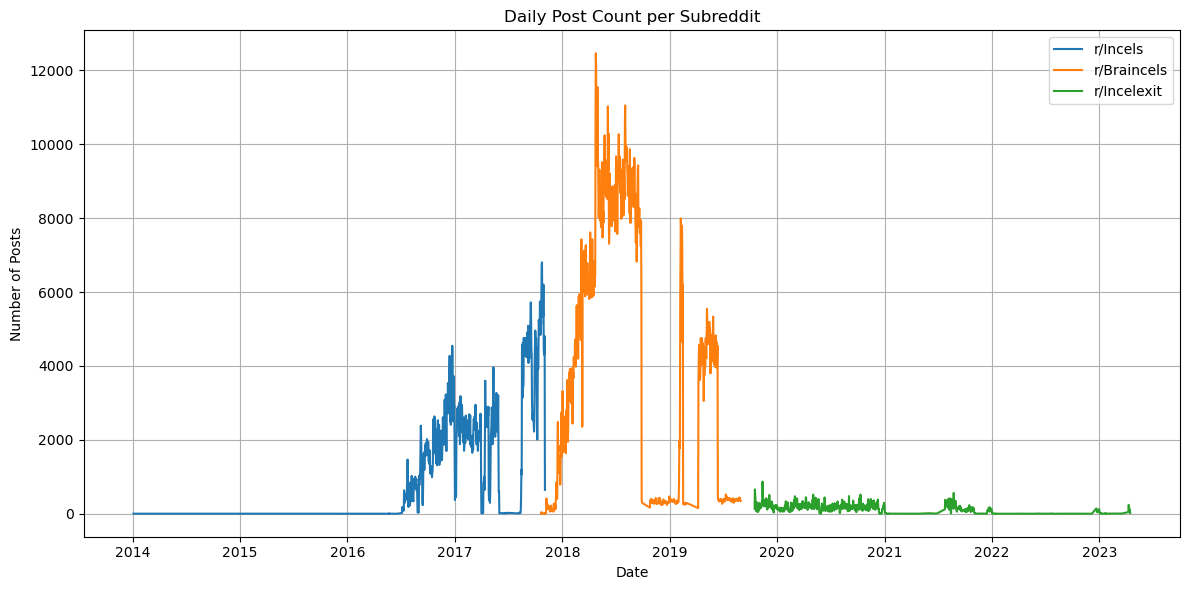

In [28]:
import matplotlib.pyplot as plt
from prettytable import PrettyTable

##r/Incels
posts_per_user_incels = valid_posts_incels.groupby('user_id').size()
users_more_five_incels = len(posts_per_user_incels[posts_per_user_incels>=5])

##r/Braincels
posts_per_user_braincels = valid_posts_braincels.groupby('user_id').size()
users_more_five_braincels = len(posts_per_user_braincels[posts_per_user_braincels>=5])

##r/IncelExit
posts_per_user_incelexit = valid_posts_incelexit.groupby('user_id').size()
users_more_five_incelexit = len(posts_per_user_incelexit[posts_per_user_incelexit>=5])

table = PrettyTable()
table.field_names = ['Dataset', 'Posts', 'Users', 'Users with more than 5 words', 'Start Date', 'End Date']
table.add_row(['r/Incel', len(valid_posts_incels), valid_posts_incels['user_id'].nunique(), users_more_five_incels, valid_posts_incels['timestamp'].dropna().iloc[0],valid_posts_incels['timestamp'].dropna().iloc[-1]])
table.add_row(['r/Braincels', len(valid_posts_braincels), valid_posts_braincels['user_id'].nunique(), users_more_five_braincels, valid_posts_braincels['timestamp'].dropna().iloc[0],valid_posts_braincels['timestamp'].dropna().iloc[-1]])
table.add_row(['r/IncelExit', len(valid_posts_incelexit), valid_posts_incelexit['user_id'].nunique(), users_more_five_incelexit, valid_posts_incelexit['timestamp'].iloc[0],valid_posts_incelexit['timestamp'].dropna().iloc[-1]])

print(table)

#Daily Posts Count
import matplotlib.pyplot as plt
import pandas as pd

valid_posts_incels['date'] = valid_posts_incels['timestamp'].dt.date
valid_posts_braincels['date'] = valid_posts_braincels['timestamp'].dt.date
valid_posts_incelexit['date'] = valid_posts_incelexit['timestamp'].dt.date

# Posts per day
daily_incels = valid_posts_incels.groupby('date').size().reset_index(name='posts')
daily_braincels = valid_posts_braincels.groupby('date').size().reset_index(name='posts')
daily_incelexit = valid_posts_incelexit.groupby('date').size().reset_index(name='posts')

plt.figure(figsize=(12, 6))
plt.plot(daily_incels['date'], daily_incels['posts'], label='r/Incels')
plt.plot(daily_braincels['date'], daily_braincels['posts'], label='r/Braincels')
plt.plot(daily_incelexit['date'], daily_incelexit['posts'], label='r/Incelexit')

plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.title('Daily Post Count per Subreddit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Next, a mapping of the number of posts per user for each subreddit was drawn, in order to early identify potential "super users" or at least check if there were users with significant activity across several fora. In particular, it was possible to identify that one particular user ('924980486.069293') was appearing with an abnormal number of posts across the three datasets. In theory, this could be an indication of promising results, especially when analyzing interactions between communities. However, after extensive research (including revisiting the archived forums), it was concluded that this user_id was attributed to every username that had a deleted account. Also, the same user_id appeared mulitple times in both the 'title' and 'text' columns, which also represented any deleted posts or titles, which indicated that the previous hypothesis might not come to fruition.

A plot showing average posting activity per user across all three communities is created, suggesting similar significant per-user engagement for all subreddits, showing their relevance for this study.


Post per user in r/Incels: <bound method Series.reset_index of user_id
924979745.996053    180211
924980486.069293     76985
925972630.579495      7703
925032756.090449      6692
924992892.192931      5907
                     ...  
939515210.492353         1
939514573.900932         1
939514203.676896         1
939513288.700478         1
924978935.238454         1
Name: count, Length: 29876, dtype: int64>
Posts per user in r/Braincels: user_id
924980486.069293    238140
924979690.842757     50137
925121378.565168     18146
933555723.872259     16126
925779251.675878     13425
                     ...  
942881668.673684         1
942882934.830604         1
942885234.814981         1
942885888.486905         1
924978959.98047          1
Name: count, Length: 75266, dtype: int64
Posts per user in r/Incelexit: user_id
924980486.069293    35004
924998581.49679      5112
925006802.224807     3762
925489165.095947     1742
925973704.552935     1528
                    ...  
926500023.423802  

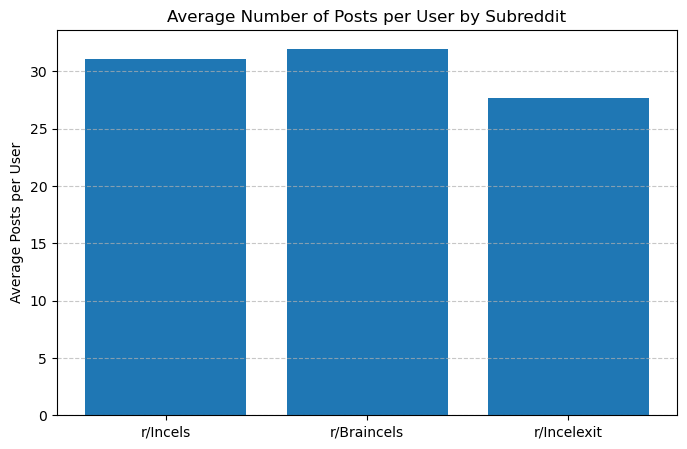

In [26]:
#Average Posts per User
print('Post per user in r/Incels:', valid_posts_incels['user_id'].value_counts().reset_index)
print('Posts per user in r/Braincels:', valid_posts_braincels['user_id'].value_counts())
print('Posts per user in r/Incelexit:', valid_posts_incelexit['user_id'].value_counts())

user_posts = valid_posts_incels[valid_posts_incels['user_id'] == 924979745.996053]
start_date_superuser = valid_posts_incels['timestamp'].min()
end_date_superuser = valid_posts_incels['timestamp'].max()
print(f"SuperUser 924979745.996053  posted from {start_date_superuser} to {end_date_superuser}")

avg_posts_incels = valid_posts_incels['user_id'].value_counts().mean()
avg_posts_braincels = valid_posts_braincels['user_id'].value_counts().mean()
avg_posts_incelexit = valid_posts_incelexit['user_id'].value_counts().mean() 

subreddits = ['r/Incels', 'r/Braincels', 'r/Incelexit']

plt.figure(figsize=(8, 5))
plt.bar(subreddits, [avg_posts_incels,avg_posts_braincels, avg_posts_incelexit ])
plt.ylabel('Average Posts per User')
plt.title('Average Number of Posts per User by Subreddit')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The final step in the data preparation notebook is to create a large dataset compiling all three subsets, ready to be applied for network construction. As seen before, the user_id '924980486.069293' appeared an abnormal amount of times either in the 'user_id' and 'text' columns, representing deleted users and comments. As such, a decision waas to remove both users and posts that contained. It is possible to observe that the dataset size suffers a reduction of around 10%; however, the total number of posts is still over 3 million, in our opinion, a still large enough dataset to achieve meaningful conclusions to our research questions. 

An additional column is added to this dataset ('Original User Source') identifying the subreddit where the user_id for a said post originated from (meaning where they posted for the first time). Finally, the compiled dataset is exported as a csv file for future use.

In [27]:
#Create compiled dataset
reddit_dataset_compiled = pd.concat([valid_posts_incels, valid_posts_incelexit, valid_posts_braincels])
print(reddit_dataset_compiled.shape)

#dropping rows for identified deleted user and posts
reddit_dataset_compiled = reddit_dataset_compiled[reddit_dataset_compiled['user_id'] != '924980486.069293']
reddit_dataset_compiled_clean = reddit_dataset_compiled[reddit_dataset_compiled['title'] != '924980486.069293'] 

print(reddit_dataset_compiled_clean.shape)

#Create column with the first subreddit each user posted in based on timestamp
first_posts = reddit_dataset_compiled_clean.sort_values('timestamp').groupby('user_id').first()['Original File Source'].reset_index()
first_posts.columns = ['user_id', 'Original User Source']

reddit_dataset_compiled_clean = reddit_dataset_compiled_clean.merge(first_posts, on='user_id', how='left')
print(reddit_dataset_compiled_clean.shape)

reddit_dataset_compiled_clean.to_csv("data/reddit_dataset_compiled_clean.csv", sep=',', index=False, encoding='utf-8')
save_path = "data/reddit_dataset_compiled_clean.csv"

(3507355, 9)
(3098242, 9)
(3098242, 10)
